In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [5]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


In [6]:
# cuDNN 최적화 
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [7]:
# 모든 변수 CUDA 상태 일괄 확인

def check_all_cuda_status():
    '''현재 namespace의 모든 변수 CUDA 상태 확인'''

    # 전역 변수 가져오기
    global_vars = globals()

    cuda_vars = []
    cpu_vars = []
    non_tensor_vars = []

    for var_name, var_value in global_vars.items():
        # 시스템 변수 제외
        if var_name.startswith('_'):
            continue
            
        # PyTorch 텐서인지 확인
        if isinstance(var_value, torch.Tensor):
            if var_value.is_cuda:
                cuda_vars.append(var_name)
            else:
                cpu_vars.append(var_name)
        
        # PyTorch 모델인지 확인
        elif isinstance(var_value, nn.Module):
            try:
                if next(var_value.parameters()).is_cuda:
                    cuda_vars.append(f"{var_name} (model)")
                else:
                    cpu_vars.append(f"{var_name} (model)")
            except StopIteration:
                # 파라미터가 없는 모델
                non_tensor_vars.append(f"{var_name} (empty model)")
        
        # 기타 변수들
        else:
            non_tensor_vars.append(var_name)
    
    # 결과 출력
    print("=== CUDA 상태 확인 결과 ===")
    print(f"\n✅ CUDA에 있는 변수들 ({len(cuda_vars)}개):")
    for var in cuda_vars:
        print(f"  - {var}")
    
    print(f"\n❌ CPU에 있는 변수들 ({len(cpu_vars)}개):")
    for var in cpu_vars:
        print(f"  - {var}")
    
    print(f"\n➖ 텐서/모델이 아닌 변수들 ({len(non_tensor_vars)}개):")
    for var in non_tensor_vars[:10]:  # 처음 10개만 표시
        print(f"  - {var}")
    if len(non_tensor_vars) > 10:
        print(f"  ... 및 {len(non_tensor_vars) - 10}개 더")
    
    return cuda_vars, cpu_vars, non_tensor_vars

In [8]:
# check_all_cuda_status()

In [9]:
import gc
# cuda cache 정리
torch.cuda.empty_cache()
gc.collect()

20

In [10]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [11]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [12]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [13]:
# build the dataset
block_size = 8 # context length : how many characters do we take to predict the next one?
def build_dataset(words):
    X,Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)  
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80% training set
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% dev=validation set
Xte, Yte = build_dataset(words[n2:])      # 10% test set

Xtr = Xtr.to(device)
Ytr = Ytr.to(device)
Xdev = Xdev.to(device)
Ydev = Ydev.to(device)
Xte = Xte.to(device)
Yte = Yte.to(device)

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [14]:
for x,y in zip(Xtr[:20],Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [34]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note : kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    def to(self, device):
        self.weight = self.weight.to(device)
        if self.bias is not None:
            self.bias = self.bias.to(device)
        return self
    
# --------------------------------------------------------------------
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    def to(self, device):
        self.gamma = self.gamma.to(device)
        self.beta = self.beta.to(device)
        self.running_mean = self.running_mean.to(device)
        self.running_var = self.running_var.to(device)
        return self
    
#------------------------------------------------------------------- 
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []   
    
    def to(self, device):
        return self 

#-------------------------------------------------------------------- 
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
    def to(self, device):
        self.weight = self.weight.to(device)
        return self
    
# --------------------------------------------------------------------
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self,x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1 :
            x = x.squeeze(1)
        self.out = x
        return self.out
    # 33:30부터
    
    def parameters(self):
        return []  
    
    def to(self, device):
        return self 
    
# --------------------------------------------------------------------
class Sequential:

    def __init__(self, layers):
        '''받은 layer list를 객체의 속성으로 저장한다.'''
        self.layers = layers

    def __call__(self, x):
        '''객체를 함수처럼 호출하게 해준다.'''
        for layer in self.layers:
            # 첫 번째 레이어의 출력이 두 번째 레이어의 입력이 되는 식으로, x를 update하면서 연쇄적으로 처리한다.
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]
    
    def to(self, device):
        for layer in self.layers:
            layer.to(device)
        return self


In [16]:
torch.manual_seed(42);

### we changed 'n_hidden' 200 to 68.
This way, the total number of neurons becomes similar to before, around 22,000.
Now, we can check whether we are using a more efficient architecture.

In [ ]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

# model = Sequential([
#     Embedding(vocab_size, n_embd),
#     FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ])

# hierarchical network
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden),
    Linear(n_hidden, vocab_size),
])

# 모든 layer를 device로 이동
model.to(device)

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

for i, p in enumerate(parameters):
    p = p.to(device)  

76579


In [23]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
# [4,8] : 4 because we picked four numbers, 8 is block_size
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  3,  9],
        [ 0,  0,  0,  0,  0,  0,  5, 13]], device='cuda:0')

In [37]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

# FlattenConsecutive의 shape를 중점으로 보자.
# FlattenConsecutive : (4, 4, 20)
# FlattenConsecutive : (4, 2, 400)  
# FlattenConsecutive : (4, 400)
# 점차 모아지고 있는 것을 볼 수 있다.  

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [39]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [ ]:
model.layers[0].out.shape # output of Embedding layer

torch.Size([4, 8, 10])

In [ ]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [ ]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [ ]:
(torch.randn(4,4,20) @ torch.randn(20,200) + torch.randn(200)).shape
# How it works?
# In the Pytorch, the matrix multiplication only works on the last Dimension.
# (for upward example torch.randn(4,5,2,80), it is 80)
# and the dimension before it in the input tensor are left unchanged.

torch.Size([4, 200])

In [33]:
# batchnorm dimension setting problem
# e.mean, e.var has dim option. we can set dim not only int, but also tuple
e = torch.randn(32, 4, 68)
emean = e.mean(dim = (0,1), keepdim=True) # 1, 4, 68
evar = e.var(dim = (0,1), keepdim=True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68

In [47]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    ix = ix.to(device)
    Xb,Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2797
  10000/ 200000: 1.8250
  20000/ 200000: 1.9877
  30000/ 200000: 2.0539
  40000/ 200000: 2.0789
  50000/ 200000: 1.9039
  60000/ 200000: 1.5710
  70000/ 200000: 2.2354
  80000/ 200000: 1.8994
  90000/ 200000: 1.9542
 100000/ 200000: 1.6573
 110000/ 200000: 1.9997
 120000/ 200000: 1.9635
 130000/ 200000: 2.2157
 140000/ 200000: 2.2139
 150000/ 200000: 2.0041
 160000/ 200000: 2.0841
 170000/ 200000: 2.0995
 180000/ 200000: 1.3333
 190000/ 200000: 1.8939


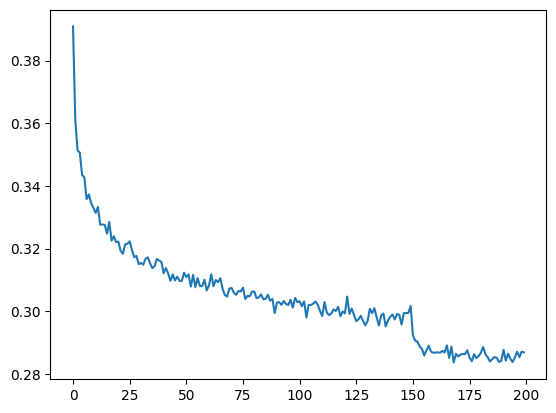

In [41]:
# torch.Size([200, 1000]) 열방향(행)으로 합산해서,총 200행, 평균을 구함.
# 매 1000번의 loss.log10()를 평균 낸것과 같음
# 150, 즉 150000번째에 learning decay
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [42]:
# put layers into eval mode (needed for batchroom expecially)
for layer in model.layers:
    layer.training = False

In [44]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9112955331802368
val 2.0136094093322754


### Performance log
- original (3 character context + 200 hidden neurons, 12k params): train 2.058, val 2.105
- context: 3 -> 8 (22k params): train 1.918, val 2.027

In [45]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

krisari.
rowen.
pendley.
annes.
mairis.
kiona.
braesha.
brionna.
kamerin.
wiston.
ionyu.
uniciah.
sulismah.
viese.
abdir.
lean.
kahlyn.
sterley.
rosell.
melish.


Why convolutions? Brief preview/hint

In [48]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> h
.......h ---> i
......hi ---> l
.....hil ---> t
....hilt ---> o
...hilto ---> n
..hilton ---> .
........ ---> j


In [49]:
# forward a single example
logits = torch.zeros(8,27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])
logits.shape

C:\Users\user\AppData\Local\Temp\ipykernel_18264\2301353236.py:46: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  xvar = x.var(dim, keepdim=True, unbiased=True) # batch variance


torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space